# Renta de bicicletas - web app para demanda de renta de bicicletas usando estimaciones por coeficientes

El set de datos usado en este analisis es compartido por [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) El centro para aprendizaje automatico y sistemas intelgentes. El set de datos contiene los registros por hora y conteo diario de renta de bicicletas entre los años 2011 y 2012 por [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) con la correspondiente informacion sobre clima y temporadas.

## Atributos de este set de datos

El set contiene dos archivos en formato csv, hour.csv y day.csv con los siguientes campos:

* instant: Indice
* dtaday: Fecha
* temporada: Temparadas (1-primavera, 2-verano, 3-otoño, 4-invierno)
* yr: Año (0-2001, 1-2012)
* mnth: mes (1 a 12)
* hr: Hora (0 a 23)
* holiday: Dia festivo o no
* weekday: Dia de la semana
* workday: Dia laboral 1 o 0
* weathersit: 1-despejado, 2-neblina, 3-nieve, 4-lluvia
* temp: Temperatura en Celsius
* atemp: Temperatura al tacto
* hum: Humedad
* windspeed: Velocidad del viento
* casual: Usuarios casuales
* registered: Usuarios registrados
* cnt: Renta total de bicicletas

## Importamos los modulos Python necesarios para el analisis

In [11]:
# Modulos para operaciones numericas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from math import sqrt
# Modulos de aprendizaje automatico
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Modulos para manejo de datos
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
# Modulos para advertencias y configuracion del ambiente
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Cargamos los datos directamente desde UCI

In [12]:
zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'

with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('/tmp/Bike-Sharing-Dataset')
        
bike_hours = pd.read_csv('/tmp/Bike-Sharing-Dataset/hour.csv')
bike_days = pd.read_csv('/tmp/Bike-Sharing-Dataset/day.csv')

Una vez cargado nuestro set de datos es posibles ver su contenido y estadisticas

In [13]:
bike_hours['temp'].describe()

count    17379.000000
mean         0.496987
std          0.192556
min          0.020000
25%          0.340000
50%          0.500000
75%          0.660000
max          1.000000
Name: temp, dtype: float64

Revisamos las primeras cinco lineas de cada una de las tablas

In [14]:
bike_hours.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [16]:
bike_days.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Analisis exploratorio de los datos (EDA)

In [18]:
bike_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [19]:
bike_hours.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Una de las variables mas importantes para el modelo es 'cnt' que representa la renta total de la bicicletas

In [20]:
bike_hours['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Podemos ver que por cada hora de registros hubo un rango minimo de una renta dentro de una hora, hasta un maximo de 977, el promedio de rentas es de 189.5. Podemos confirmar que se trata de una caracteristica numérica continua en donde se puede usar un modelo de regresion lineal para entrenar un modelo y obtener las predicciones.

La manera mas sencilla de entender los datos completos es con una grafica

Text(0.5, 0.98, 'Registro de rentas')

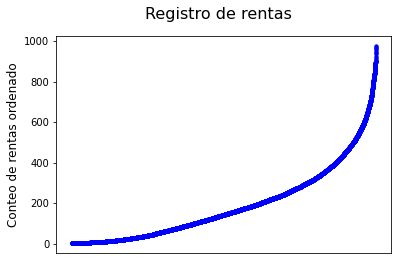

In [21]:
fig, ax = plt.subplots(1)
ax.plot(sorted(bike_hours['cnt']), color='blue', marker='.')
ax.xaxis.set_visible(False)
ax.set_ylabel('Conteo de rentas ordenado', fontsize=12)
fig.suptitle('Registro de rentas', fontsize=16)

Las graficas de dispersion no ayudaran a visualizar relaciones potenciales

## Caracteristicas cuantitativas contra conteo de rentas

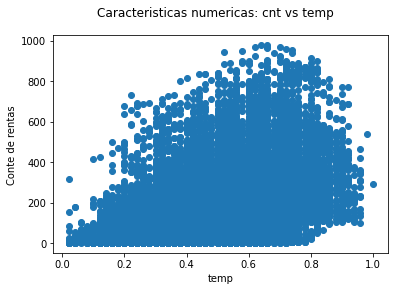

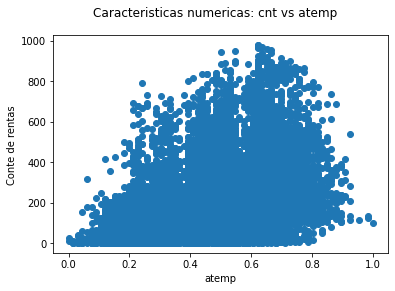

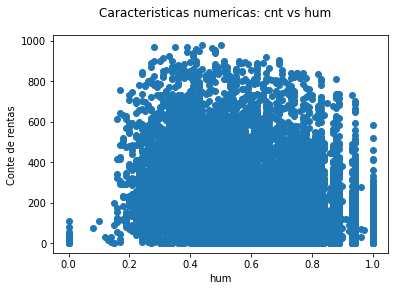

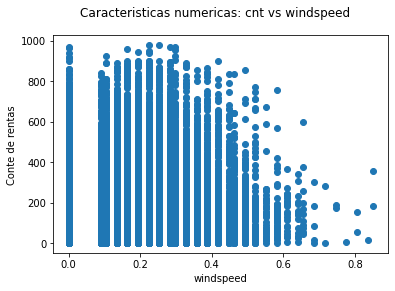

In [29]:
# Bucle para encontrar datos
counter = 0
for i in bike_hours.dtypes:
    if (i == 'float64'):
        bikes_hours = bike_hours.sort_values(bike_hours.dtypes.index[counter])
        feature = bike_hours.dtypes.index[counter]
        plt.scatter(bike_hours[feature], bike_hours['cnt'])
        plt.suptitle('Caracteristicas numericas: cnt vs ' + feature)
        plt.xlabel(feature)
        plt.ylabel('Conte de rentas')
        plt.show()
    counter += 1

Podemos ver que la caracteristica de temperatura muestra una relacion lineal entre las rentas y la temperatura, entre mas calido mas rentas, la temperatura al tacto es muy similar con temperatura por lo que es bueno retirarla del set parea evitar colinearidad.

## Mirando las caracteristicas categoricas

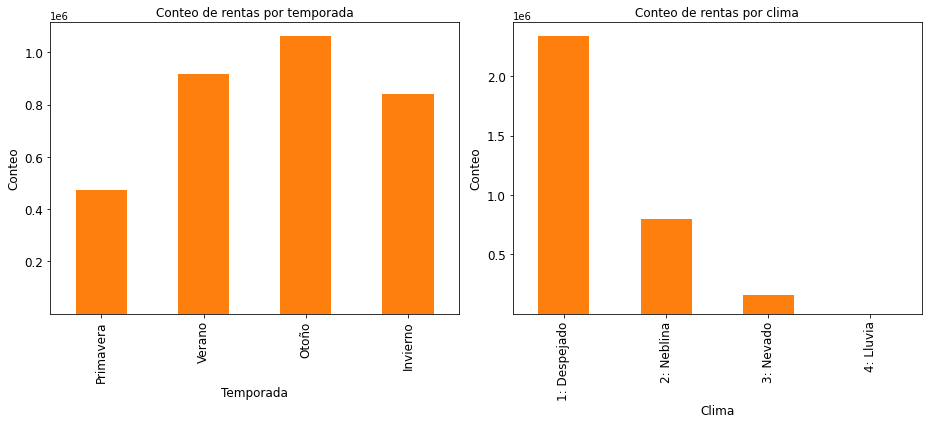

In [32]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

ax1 = bike_hours[['season','cnt']].groupby(['season']).sum().reset_index().plot(kind='bar',
                                       legend = False, title ="Conteo de rentas por temporada", 
                                         stacked=True, fontsize=12, ax=ax1)
ax1.set_xlabel("Temporada", fontsize=12)
ax1.set_ylabel("Conteo", fontsize=12)
ax1.set_xticklabels(['Primavera','Verano','Otoño','Invierno'])

ax2 = bike_hours[['weathersit','cnt']].groupby(['weathersit']).sum().reset_index().plot(kind='bar',  
      legend = False, stacked=True, title ="Conteo de rentas por clima", fontsize=12, ax=ax2)

ax2.set_xlabel("Clima", fontsize=12)
ax2.set_ylabel("Conteo", fontsize=12)
ax2.set_xticklabels(['1: Despejado','2: Neblina','3: Nevado','4: Lluvia'])

f.tight_layout()

Comunmente las personas rentaran bicicletas cuando el clima y temporadas son mas agradables por ejemplo en otoño y verano cuando el cielo esta despejado.

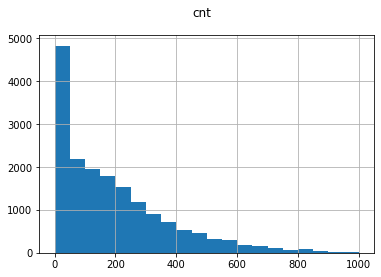

In [33]:
bike_hours['cnt'].hist(bins=20, range=(0,1000)).plot()
plt.suptitle('cnt')
plt.show()

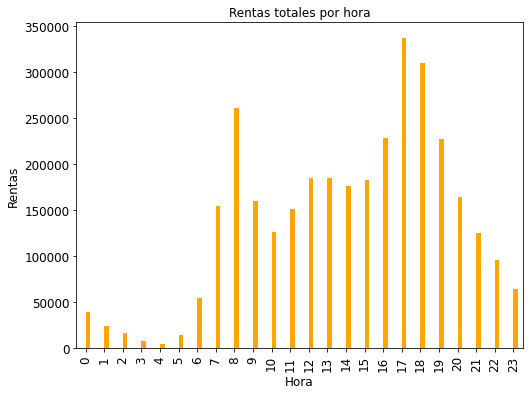

In [36]:
ax = bike_hours[['hr','cnt']].groupby(['hr']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Rentas totales por hora", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Hora", fontsize=12)
ax.set_ylabel("Rentas", fontsize=12)
plt.show()

Igualmente las horas con mayor renta de bicicletas son las horas pico de trabajos de oficina y siendo la madrugada los puntos mas bajos.

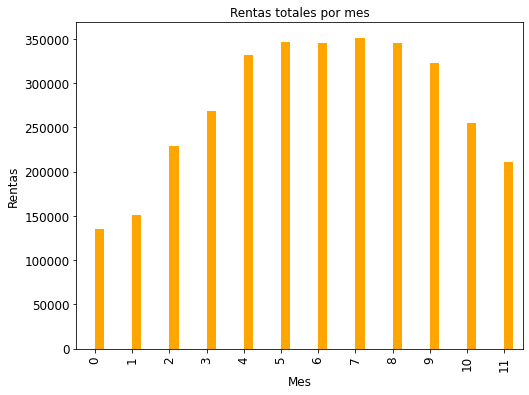

In [37]:
ax = bike_hours[['mnth','cnt']].groupby(['mnth']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Rentas totales por mes", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Rentas", fontsize=12)
plt.show()

## Preparando los datos para modelar

La mayoria de proyectos de ciencia de datos tienen un fase de limpieza y preparacion para dejarlos listos para el modelo.

### Modelos de regresion

En analisis estadistico, los modelos de regresion intentan predecir la relacion entre variables. Un modelo ajustado puede ser usado para predecir nuevas variables dependientes.

### Regresion lineal simple

La regresion lineal es probablemente el mas simple de los algoritmos, intenta explicar la relacion entre una variable dependiente y una o mas variables independientes.